In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns

# outline


## features:
1. sharpe ratio
2. volume
3. hurst_exponent
4. open
5. close
6. high
6. low


## label:
1. 100% mean reversion, 0% momentum
2. 75% mean reversion, 25% momentum
3. 50% mean reversion, 50% momentum
4. 25% mean reversion, 75% momentum
5. 0% mean reversion, 100% momentum


## approach:
### feature generation: 
for each day (i), compute the features mentioned above

### label generation: 
for each day (i), apply two strategies according to the weights given by the label. 

choose the weight which gives the best pnl over the next 20 days (i+1:i+20)

### training:
use every 20 days' (i-10: i) indicator to train to predict the label at (i) 


### outcome
we will have a daily prediction of best portfolio according to data in the past 20 days.

We then use majority vote for the past 10 days to decide which strategy to use

In [2]:
# Load data
df = pd.read_csv("/Users/jingang/Desktop/Capstone/SPY.csv")
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
Price = df.loc[:,"Adj Close"]
Price=Price.loc[(Price.index>"1980-01-01") & (Price.index<"2018-01-01")]
Volume = df.loc[:,"Volume"]
Price.head()
Open = df.loc[:,"Open"]
Open=Open.loc[(Open.index>"1980-01-01") & (Open.index<"2018-01-01")]
High = df.loc[:,"High"]
High=High.loc[(High.index>"1980-01-01") & (High.index<"2018-01-01")]
Low = df.loc[:,"Low"]
Low=Low.loc[(Low.index>"1980-01-01") & (Low.index<"2018-01-01")]
Close = df.loc[:,"Close"]
Close=Close.loc[(Close.index>"1980-01-01") & (Close.index<"2018-01-01")]

# generate features

## functions to generate features
1. sharpe ratio
2. volume
3. hurst_exponent
4. open
5. close
6. high
6. low

In [3]:
def compute_sharpe(arr):
    ret = np.divide(np.diff(arr),arr[:-1])
    return(np.mean(ret)/np.std(ret)) 

In [4]:
def compute_range(arr):
    ret = np.divide(np.diff(arr),arr[:-1])
    return max(ret) - min(ret)

In [5]:
def compute_interquartile(arr):
    ret = np.divide(np.diff(arr),arr[:-1])
    return np.percentile(ret,75)-np.percentile(ret,25)

In [6]:
def compute_vol(arr):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    vol = np.float(np.sqrt(np.cov(return_arr)))
    return vol

In [7]:
def compute_hurst_exponent(arr):
    num_lag = 18
    lag_arr = np.arange(2,2+num_lag)
    tau_arr = np.zeros(num_lag)
    #  Step through the different lags
    for i in range(num_lag):
        lag = lag_arr[i]
        #  produce price difference with lag
        arr_diff = np.diff(arr,lag)
        #  Calculate the variance of the differnce vector
        tau_arr[i] = np.sqrt(np.std(arr_diff))
    #  linear fit to double-log graph (gives power)
    m = np.polyfit(np.log10(lag_arr),np.log10(tau_arr),1)
    # calculate hurst
    hurst = m[0]*2
    return hurst

In [8]:
def compute_long_short_scale_vol_ratio(arr, long_scale ,short_scale=1):
    arr_long_scale = arr[::long_scale]
    arr_short_scale = arr[::short_scale]
    
    return compute_vol(arr_short_scale)/compute_vol(arr_long_scale)

In [9]:
def compute_autocorr(arr, lag):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    mat_autocov = np.cov(return_arr[lag:],return_arr[:-lag])
    autocorr = mat_autocov[1,0]/np.sqrt(mat_autocov[0,0]*mat_autocov[1,1])
    return autocorr

In [10]:
# create the indicator
window_indicators = 30
Indicators = pd.DataFrame(index = Price.index, columns=["hurst_exponent",
                                                        "sharpe_ratio",
                                                        "Volume",
                                                        'Open_pct',
                                                        'Close_pct',
                                                       'High_pct',
                                                       'Low_pct',
                                                       'Open',
                                                       'Price',
                                                       'Close'])
Indicators.loc[:,"hurst_exponent"] = Price.rolling(window=window_indicators).apply(compute_hurst_exponent)
Indicators.loc[:,"sharpe_ratio"] = Price.rolling(window=window_indicators).apply(compute_sharpe)
Indicators.loc[:,"Volume"] = Volume
Indicators.loc[:,"Low_pct"] = Low.pct_change()
Indicators.loc[:,"High_pct"] = High.pct_change()
Indicators.loc[:,"Close_pct"] = Close.pct_change()
Indicators.loc[:,"Open_pct"] = Open.pct_change()
Indicators.loc[:,"Open"] = Open
Indicators.loc[:,"Price"] = Price
Indicators.loc[:,"Close"] = Close

In [24]:
Indicators[30:].head()

,hurst_exponent,sharpe_ratio,Volume,Open_pct,Close_pct,High_pct,Low_pct,Open,Price,Close
Date,,,,,,,,,,
2000-02-15,5.258879,0.027300,11078300,-0.003800,0.011313,0.010284,-0.003729,139.2500,100.695770,141.078094
2000-02-16,5.287110,-0.005176,8845400,0.008079,-0.014730,-0.001991,0.007257,140.3750,99.212517,139.000000
2000-02-17,5.338493,0.016244,7584200,0.000445,-0.005171,-0.003548,-0.004165,140.4375,98.699432,138.281204
2000-02-18,5.341500,-0.174040,9409200,-0.011126,-0.021469,-0.011126,-0.026000,138.8750,96.580505,135.312500
2000-02-22,5.318577,-0.189204,16415400,-0.026553,-0.002541,-0.018227,-0.008125,135.1875,96.335106,134.968704


In [25]:
Indicators_useful_bn = Indicators[30:]
Indicators_useful_bn.head()

,hurst_exponent,sharpe_ratio,Volume,Open_pct,Close_pct,High_pct,Low_pct,Open,Price,Close
Date,,,,,,,,,,
2000-02-15,5.258879,0.027300,11078300,-0.003800,0.011313,0.010284,-0.003729,139.2500,100.695770,141.078094
2000-02-16,5.287110,-0.005176,8845400,0.008079,-0.014730,-0.001991,0.007257,140.3750,99.212517,139.000000
2000-02-17,5.338493,0.016244,7584200,0.000445,-0.005171,-0.003548,-0.004165,140.4375,98.699432,138.281204
2000-02-18,5.341500,-0.174040,9409200,-0.011126,-0.021469,-0.011126,-0.026000,138.8750,96.580505,135.312500
2000-02-22,5.318577,-0.189204,16415400,-0.026553,-0.002541,-0.018227,-0.008125,135.1875,96.335106,134.968704


In [26]:
# normalize the data
Indicators_useful = Indicators_useful_bn.loc[:,["hurst_exponent",
                                                "sharpe_ratio",
                                                        "Volume",
                                                        'Open_pct',
                                                        'Close_pct',
                                                       'High_pct',
                                                       'Low_pct']]

data = ["hurst_exponent","sharpe_ratio","Volume",'Open_pct', 'Close_pct','High_pct','Low_pct']

for i in data:
    Indicators_useful[i] = (Indicators_useful[i]-Indicators_useful[i].mean())/Indicators_useful[i].std()

In [28]:
Indicators_useful.head(10)

,hurst_exponent,sharpe_ratio,Volume,Open_pct,Close_pct,High_pct,Low_pct
Date,,,,,,,
2000-02-15,0.899907,-0.241543,-1.024073,-0.334121,0.912283,1.050023,-0.339639
2000-02-16,1.039343,-0.425600,-1.045858,0.653755,-1.229176,-0.227080,0.606886
2000-02-17,1.293125,-0.304204,-1.058163,0.018933,-0.443156,-0.389008,-0.377250
2000-02-18,1.307977,-1.382640,-1.040357,-0.943325,-1.783277,-1.177447,-2.258574
2000-02-22,1.194756,-1.468581,-0.972002,-2.226208,-0.226858,-1.916252,-0.718422
2000-02-23,1.057720,-1.132079,-1.013919,0.251033,0.953079,0.838540,0.606725
2000-02-24,0.847696,-1.253019,-0.962639,0.633390,-1.673805,-0.351020,-0.919260
2000-02-25,0.563988,-1.507360,-1.029131,-0.930684,-0.315606,-0.257172,0.001873
2000-02-28,0.264188,-1.381192,-1.001443,-1.133042,1.707036,-0.043656,-0.281349


## build a rolling indicator 

In [29]:
Indicators_useful_bloc = Indicators_useful.ewm(20).mean()

# generate pnl label

There are two trading strategies:

* mean reversion:

* use 20 day's ewm with std 1.2:

    * when price cross upper band from below, short;

    * when price cross middle band from above, close

    * when price cross lower band from above, long;

    * when price cross middle band from below, close




* momentum:

* use hist line in MACD indicator:

    * when hist increase for 4 consecutive days  and  hist < 0, long

    * when hist cross 0 from below, close

    * when hist decreases for 4 consecutive days and hist > 0, short

    * when hist cross 0 from above, close

## mean reversion strategy
start from a certain day (i), check the pnl of next 20 days, return the value of pnl

In [30]:
# compute the bollinger_band
def compute_bollinger_band(series=Price, span=20, num_std=1.2):
    bollinger_band_middle = Price.ewm(span=span).mean()
    rolling_std = Price.ewm(com=9.5).std()
    bollinger_band_upper = bollinger_band_middle+rolling_std*num_std
    bollinger_band_lower = bollinger_band_middle-rolling_std*num_std
    return bollinger_band_upper,bollinger_band_middle, bollinger_band_lower

In [31]:
# take a date i and a window of fixed length (20)
# return index of i+1 and i+20
def get_window(date, series=Price, window_length = 20):
    date = pd.to_datetime(date)
    date_index = Price.index.get_loc(date)
    return date_index+1, date_index+window_length

In [32]:
# EMA indicator for the whole series
bb_upper, bb_middle, bb_lower = compute_bollinger_band(Price, span=20, num_std=1.2)

In [33]:
def mean_reversion_strategy(date, series=Price, long_window=20, num_std=1.2,  window_length = 20):
     
            
    # EMA indicator
    #bb_upper, bb_middle, bb_lower = compute_bollinger_band(series, long_window, num_std)
    
    # periods
    window_index_s, window_index_e = get_window(date = date, series=series, window_length = 20)
    
        
    current_period = series[window_index_s:window_index_e+1]
    current_upper = bb_upper[window_index_s:window_index_e+1]
    current_middle = bb_middle[window_index_s:window_index_e+1]
    current_lower = bb_lower[window_index_s:window_index_e+1]
      
    plt.plot(current_upper,'r-')  
    plt.plot(current_middle,'g-')  
    plt.plot(current_lower,'r-')  
    plt.plot(current_period,'b.-')
    plt.show()
    
    # notice the the indicators are designed such that there is no chance of them overlap
    # price cross lower from above
    long_indicator = np.all([current_period < current_lower, current_period.shift(1) > current_lower.shift(1)], axis=0)
        
    # price cross middle from below
    close_long_indicator = np.all([current_period > current_middle, current_period.shift(1) < current_middle.shift(1)], axis=0)
    
    # price cross middle from above
    close_short_indicator = np.all([current_period < current_middle, current_period.shift(1) > current_middle.shift(1)], axis=0)
        
    # price cross upper from below
    short_indicator = np.all([current_period > current_upper, current_period.shift(1) < current_upper.shift(1)], axis=0)
        

    # make the strategy
    # if eixst position, close it anyway at end of the period
    position = 0
    pnl = 0
    pre_price = 0
    count = 0
    for j in range(window_length):
                
        # long indicator is activated
        if long_indicator[j] == True and position == 0:
            position = 1
            pre_price = current_period[j]
                
        # close long indicator is activated
        if close_long_indicator[j] == True and position == 1:
            position = 0
            pnl += current_period[j] - pre_price
            pre_price = 0
            count += 1
            
        # short indicator is activated
        if short_indicator[j] == True and position == 0:
            position =  -1
            pre_price = current_period[j]
            
        # close short indicator is activated
        if close_short_indicator[j] == True and position == -1:
            position = 0
            pnl += pre_price - current_period[j]
            pre_price = 0
            count += 1
                
    # close any existing position
    if position != 0:
        if position == 1:
            pnl += current_period[window_length-1] - pre_price
            count += 1
        if position == -1:
            pnl += pre_price - current_period[window_length-1]
            count += 1
                 
    return pnl, count

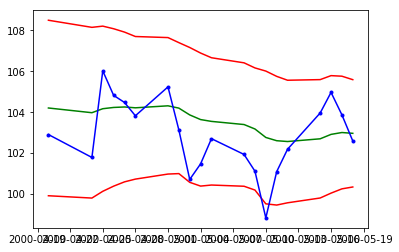

(5.120757999999995, 1)

In [34]:
mean_reversion_strategy('2000-04-19', series=Price, long_window=20, num_std=1.2,  window_length = 20)

In [35]:
def mean_reversion_strategy_backtest(date, series=Price, Open=Open, long_window=20, num_std=1.2, window_length = 20):
     
            
    # EMA indicator
    #bb_upper, bb_middle, bb_lower = compute_bollinger_band(series, long_window, num_std)
    
    # periods
    window_index_s, window_index_e = get_window(date = date, series=series, window_length = 20)
    
        
    current_period = series[window_index_s:window_index_e+1]
    current_upper = bb_upper[window_index_s:window_index_e+1]
    current_middle = bb_middle[window_index_s:window_index_e+1]
    current_lower = bb_lower[window_index_s:window_index_e+1]
    current_open = Open[window_index_s:window_index_e+2]
    '''
    plt.plot(current_upper,'r-')  
    plt.plot(current_middle,'g-')  
    plt.plot(current_lower,'r-')  
    plt.plot(current_period,'b.-')
    plt.show()
    '''
    # notice the the indicators are designed such that there is no chance of them overlap
    # price cross lower from above
    long_indicator = np.all([current_period < current_lower, current_period.shift(1) > current_lower.shift(1)], axis=0)
        
    # price cross middle from below
    close_long_indicator = np.all([current_period > current_middle, current_period.shift(1) < current_middle.shift(1)], axis=0)
    
    # price cross middle from above
    close_short_indicator = np.all([current_period < current_middle, current_period.shift(1) > current_middle.shift(1)], axis=0)
        
    # price cross upper from below
    short_indicator = np.all([current_period > current_upper, current_period.shift(1) < current_upper.shift(1)], axis=0)
        

    # make the strategy
    # if eixst position, close it anyway at end of the period
    position = 0
    pnl = 0
    pre_price = 0
    count = 0
    for j in range(window_length):
                
        # long indicator is activated
        if long_indicator[j] == True and position == 0:
            position = 1
            
            #pre_price = current_period[j]
            pre_price = current_open[j+1]  
            
        # close long indicator is activated
        if close_long_indicator[j] == True and position == 1:
            position = 0
            
            #pnl += current_period[j] - pre_price
            pnl += current_open[j+1] - pre_price
            
            pre_price = 0
            count += 1
            
        # short indicator is activated
        if short_indicator[j] == True and position == 0:
            position =  -1
            #pre_price = current_period[j]
            pre_price = current_open[j+1]  
            
            
        # close short indicator is activated
        if close_short_indicator[j] == True and position == -1:
            position = 0
            
            pnl += pre_price - current_open[j+1]
            #pnl += pre_price - current_period[j]
            
            pre_price = 0
            count += 1
                
    # close any existing position
    if position != 0:
        if position == 1:
            #pnl += current_period[window_length-1] - pre_price
            pnl += current_open[window_length] - pre_price
            count += 1
        if position == -1:
            #pnl += pre_price - current_period[window_length-1]
            pnl +=  pre_price - current_open[window_length]
            count += 1
                 
    return pnl, count

In [36]:
mean_reversion_strategy_backtest('2000-06-22', series=Price, Open=Open, long_window=20, num_std=1.2, window_length = 20)

(1.8592989999999929, 1)

## momentum strategy
start from a certain day (i), check the pnl of next 20 days, return the value of pnl

In [37]:
# generate MACD_hist
ema_26 = Price.ewm(26).mean()
ema_12 = Price.ewm(12).mean()
MACD_line = ema_12 - ema_26
Sigal_line = MACD_line.ewm(9).mean()
MACD_hist = MACD_line - Sigal_line

In [38]:
def momentum_strategy_backtest(date, series=Price, Open=Open, long_window=20,  window_length = 20):
    # EMA indicator
    #bb_upper, bb_middle, bb_lower = compute_bollinger_band(series, long_window, num_std)
    
    # periods
    window_index_s, window_index_e = get_window(date = date, series=series, window_length = 20)
    
        
    current_period = series[window_index_s:window_index_e+1]
    current_MACD_hist = MACD_hist[window_index_s:window_index_e+1]
    current_open = Open[window_index_s:window_index_e+2]

    '''
    _, ax1 = plt.subplots(figsize=(14,8))
    ax1.plot(current_MACD_hist, c='r', label='hist')
    ax1.legend(loc=2)
    ax1.grid(True)
    ax2 = ax1.twinx()
    ax2.plot(current_period, c='black', label='price')
    ax2.legend(loc=1)
    plt.show()
    '''
    # notice the the indicators are designed such that there is no chance of them overlap
    
    # hist increases 3 consecutive days
    long_indicator = np.all([current_MACD_hist.shift(-1) > current_MACD_hist, current_MACD_hist.shift(-2) > current_MACD_hist.shift(-1),current_MACD_hist.shift(-3) > current_MACD_hist.shift(-2), current_MACD_hist < 0], axis=0)
  
    # hist cross 0 from below
    close_long_indicator = np.all([current_MACD_hist.shift(1) < 0 , current_MACD_hist > 0], axis=0)

    # hist decreases 3 consecutive days
    short_indicator = np.all([current_MACD_hist.shift(-1) < current_MACD_hist, current_MACD_hist.shift(-2) < current_MACD_hist.shift(-1),current_MACD_hist.shift(-3) < current_MACD_hist.shift(-2), current_MACD_hist < 0], axis=0)
    
     # hist cross 0 from above
    close_short_indicator = np.all([current_MACD_hist.shift(1) > 0 , current_MACD_hist < 0], axis=0)
        

    # make the strategy
    # if eixst position, close it anyway at end of the period
    position = 0
    pnl = 0
    pre_price = 0
    count = 0
    for j in range(window_length):
                
        # long indicator is activated
        if long_indicator[j] == True and position == 0:
            position = 1
            
            #pre_price = current_period[j]
            pre_price = current_open[j+1]  
      
        # close long indicator is activated
        if close_long_indicator[j] == True and position == 1:
            position = 0
            
            #pnl += current_period[j] - pre_price
            pnl += current_open[j+1] - pre_price
           
            pre_price = 0
            count += 1

        # short indicator is activated
        if short_indicator[j] == True and position == 0:
            position =  -1
            #pre_price = current_period[j]
            pre_price = current_open[j+1]  
            
            
        # close short indicator is activated
        if close_short_indicator[j] == True and position == -1:
            position = 0
            
            pnl += pre_price - current_open[j+1]
            #pnl += pre_price - current_period[j]
            
            pre_price = 0
            count += 1

    # close any existing position
    if position != 0:
        if position == 1:
            #pnl += current_period[window_length-1] - pre_price
            pnl += current_open[window_length] - pre_price
            count += 1

        if position == -1:
            #pnl += pre_price - current_period[window_length-1]
            pnl +=  pre_price - current_open[window_length]
            count += 1
   
                 
    return pnl, count

In [39]:
momentum_strategy_backtest(date='2000-02-22', series=Price, Open=Open, long_window=20,  window_length = 20)

(6.8125, 1)

## combine two strategies according to the mixed weight

In [40]:
weight_mean_reversion = np.arange(0, 1.01, 0.1)
weight_momentum = 1- np.arange(0, 1.01, 0.1)

In [71]:
date = Indicators_useful.index.values

In [72]:
length = int (len(date) * .95)
label_arr = np.zeros(length)
for i in range(length):
    pnl = weight_momentum*momentum_strategy_backtest(date[i])[0] + weight_mean_reversion*mean_reversion_strategy_backtest(date[i])[0]
    label_arr[i] = np.argmax(pnl)
label = pd.DataFrame({'label':label_arr, 'Date':date[:length]}, columns=['label','Date']).set_index('Date')

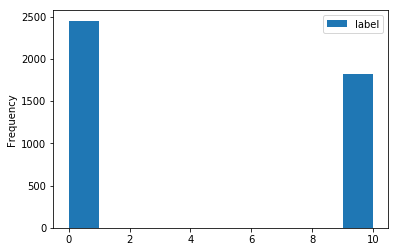

In [73]:
# 10 is mean reversion
# 0 is momentum
label.plot(kind='hist')
plt.show()

## combine two dataframes into one that we can use

In [74]:
Indicators_useful_bloc[:length].tail()

,hurst_exponent,sharpe_ratio,Volume,Open_pct,Close_pct,High_pct,Low_pct
Date,,,,,,,
2017-02-02,0.667610,0.674105,-0.367818,0.023745,0.025110,0.029049,0.024259
2017-02-03,0.673667,0.659600,-0.366786,0.042630,0.050051,0.058211,0.051894
2017-02-06,0.676936,0.645637,-0.376383,0.040603,0.039813,0.049743,0.049984
2017-02-07,0.682026,0.629111,-0.385458,0.046632,0.037235,0.053555,0.049960
2017-02-08,0.694372,0.610798,-0.397058,0.035954,0.039739,0.044232,0.039350


In [75]:
training_df = pd.concat([Indicators_useful_bloc[:length], label], axis=1)

# Model Building
We will try random forest and gradient boosting model for our task.

Notice that here we have either 10 or 0. Therefore we only use 1 and 0 as label.

The training data will be split by 4:1, 4 for training and 1 for validation

## Using a fixed weight
The weight is the exponential decaying weight

In [76]:
training_df.tail()

,hurst_exponent,sharpe_ratio,Volume,Open_pct,Close_pct,High_pct,Low_pct,label
Date,,,,,,,,
2017-02-02,0.667610,0.674105,-0.367818,0.023745,0.025110,0.029049,0.024259,0.0
2017-02-03,0.673667,0.659600,-0.366786,0.042630,0.050051,0.058211,0.051894,0.0
2017-02-06,0.676936,0.645637,-0.376383,0.040603,0.039813,0.049743,0.049984,0.0
2017-02-07,0.682026,0.629111,-0.385458,0.046632,0.037235,0.053555,0.049960,0.0
2017-02-08,0.694372,0.610798,-0.397058,0.035954,0.039739,0.044232,0.039350,10.0


In [77]:
total_length = len(training_df)
train_length = int(.8 * total_length)
test_length = total_length - train_length
train_set = training_df[:train_length]
test_set = training_df[train_length+1:]

In [78]:
# build the training and test data
n_row, n_col = train_set.shape
train_x = train_set.iloc[:,0:n_col-1]
train_y = train_set.iloc[:,n_col-1]
train_y_classification = train_y.copy()
train_y_classification[train_y_classification>5] = 1
train_y_classification = train_y_classification.astype('int32')
test_x = test_set.iloc[:,0:n_col-1]
test_y =  test_set.iloc[:,n_col-1]
test_y_classification = test_y.copy()
test_y_classification[test_y_classification>5] = 1
test_y_classification = test_y_classification.astype('int32')

In [79]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [80]:
def classification_process(estimator, train_x, train_y_classification, test_x, test_y_classification):
    estimator.fit(train_x, train_y_classification)
    test_y_predict_classification = estimator.predict(test_x)
    print ('{} accuracy = {:.2f}'.format(estimator.__class__.__name__, 
                                         metrics.accuracy_score(test_y_classification, test_y_predict_classification)))

In [92]:
estimator = GradientBoostingClassifier(n_estimators=500)
classification_process(estimator, train_x, train_y_classification, test_x, test_y_classification)

GradientBoostingClassifier accuracy = 0.57


### make inference and generate PNL for test data

In [93]:
prediction = estimator.predict(test_x)
importance = estimator.feature_importances_
features = ('sharpe ratio','volume','hurst_exponent','open','close','high','low')
for i in zip(importance, features):
    print ('importance for {0} is {1:3f}'.format(i[1], i[0]))
date = test_x.index.values
prediction_df = pd.DataFrame({'prediction':prediction, 'date':date},columns = ['prediction','date']).set_index('date')

importance for sharpe ratio is 0.159329
importance for volume is 0.250063
importance for hurst_exponent is 0.294582
importance for open is 0.085402
importance for close is 0.084123
importance for high is 0.066073
importance for low is 0.060429


In [97]:
prediction_df.tail(20)

,prediction
date,
2017-01-11,1
2017-01-12,1
2017-01-13,1
2017-01-17,1
2017-01-18,1
2017-01-19,1
2017-01-20,1
2017-01-23,1
2017-01-24,1


total pnl for 854 days is 112.010027
benchmark pnl is 60.050003


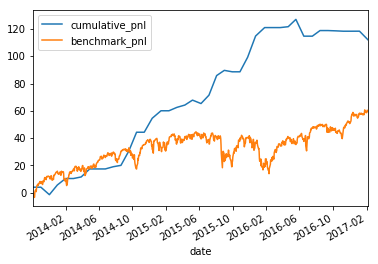

In [98]:
# generate pnl
# use majority vote
# 0 momentum, 1 mean reversion
# choose 2010-03-10 because we have labels for it 10 days before
start_date = prediction_df.index.values[11]
end_date = prediction_df.index.values[len(prediction_df)-1]
#start_date = pd.to_datetime('2010-03-10')
index = prediction_df.index.get_loc(start_date)
total_pnl = 0
pnl_record = []
date_record = []

period = []
for i in np.arange(index, len(test_x), 20):
    
    low_bound = i - 10
    information = prediction_df[low_bound:i]
    date = prediction_df.index.values[i]
    
    if information.sum().values[0]<5:
        pnl = momentum_strategy_backtest(date)[0]
        period.append(('momentum',date))
    else:
        pnl = mean_reversion_strategy_backtest(date)[0]
        period.append(('mean reversion',date))
        
    total_pnl += pnl
   
    date_record.append(test_x.index.values[i])    
    pnl_record.append(pnl) 
    
date_record = np.array(date_record)
pnl_record = np.array(pnl_record).cumsum()

s_index = Indicators_useful.index.get_loc(start_date)
e_index = Indicators_useful.index.get_loc(end_date)
bench_mark = Indicators_useful_bn[s_index:e_index]
bench_mark
bench_mark_pnl = bench_mark['Close'].diff().cumsum()

pnl_df = pd.DataFrame({'cumulative_pnl':pnl_record, 'date':date_record}, columns=['cumulative_pnl','date']).set_index('date')
end_date = pd.to_datetime(prediction_df.index.values[len(test_x)-1])

print ('total pnl for {0} days is {1:3f}'.format(len(test_x),total_pnl))  
print ('benchmark pnl is {0:3f}'.format(bench_mark['Close'][len(bench_mark)-1]-bench_mark['Close'][0]))
pnl_df.plot()
plt.plot(bench_mark_pnl, label='benchmark_pnl')
plt.legend()
plt.show()

## Using LSTM

In [ ]:
training_df = pd.concat([Indicators_useful[:length], label], axis=1)

In [ ]:
training_df.head(5)

In [ ]:
n_row, n_col = train_set.shape
train_x = train_set.iloc[:,0:n_col-1]
train_y = train_set.iloc[:,n_col-1]
train_y_classification = train_y.copy()
train_y_classification[train_y_classification>5] = 1
train_y_classification = train_y_classification.astype('int32')
test_x = test_set.iloc[:,0:n_col-1]
test_y =  test_set.iloc[:,n_col-1]
test_y_classification = test_y.copy()
test_y_classification[test_y_classification>5] = 1
test_y_classification = test_y_classification.astype('int32')

In [ ]:
test_y[:200].plot()
plt.show()